# Dealing with Categorical Features

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

plt.style.use('seaborn-notebook')

One issue we'd like to resolve is what to do with categorical features, i.e. predictors that represent categories rather than continua. In a Pandas DataFrame, these columns may well have strings or even other objects for values, but they need not. Sometimes integers are used to encode different categories, even when those categories have no natural ordering.

## Dummying - Theory

One very effective way of dealing with categorical variables is to dummy them out. What this involves is making a new column for _each categorical value in the column we're dummying out_.

These new columns will be filled only with 0's and 1's, a 1 representing the presence of the relevant categorical value.

Let's look at a simple example. This is a dataset about Australian possums and you can find it on [Kaggle](https://www.kaggle.com/datasets/abrambeyer/openintro-possum).

In [2]:
possums = pd.read_csv('data/possum.csv')

In [3]:
possums.head(20)

case  site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  \
0      1     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5   
1      2     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5   
2      3     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4   
3      4     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1   
4      5     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0   
5      6     1  Vic   f  1.0     93.1    54.8      90.5   35.5      73.2   
6      7     1  Vic   m  2.0     95.3    58.2      89.5   36.0      71.5   
7      8     1  Vic   f  6.0     94.8    57.6      91.0   37.0      72.7   
8      9     1  Vic   f  9.0     93.4    56.3      91.5   37.0      72.4   
9     10     1  Vic   f  6.0     91.8    58.0      89.5   37.5      70.9   
10    11     1  Vic   f  9.0     93.3    57.2      89.5   39.0      77.2   
11    12     1  Vic   f  5.0     94.9    55.6      92.0   35.5      71.7   
12    13     1  Vic   m  5.0     95.1    59.9      89.5   36.0      71.0   
13    14     1  Vic   m  3.0     95.4    57.6      91.5   36.0      74.3   
14    15     1  Vic   m  5.0     92.9    57.6      85.5   34.0      69.7   
15    16     1  Vic   m  4.0     91.6    56.0      86.0   34.5      73.0   
16    17     1  Vic   f  1.0     94.7    67.7      89.5   36.5      73.2   
17    18     1  Vic   m  2.0     93.5    55.7      90.0   36.0      73.7   
18    19     1  Vic   f  5.0     94.4    55.4      90.5   35.0      73.4   
19    20     1  Vic   f  4.0     94.8    56.3      89.0   38.0      73.8   

    earconch   eye  chest  belly  
0       54.5  15.2   28.0   36.0  
1       51.2  16.0   28.5   33.0  
2       51.9  15.5   30.0   34.0  
3       52.2  15.2   28.0   34.0  
4       53.2  15.1   28.5   33.0  
5       53.6  14.2   30.0   32.0  
6       52.0  14.2   30.0   34.5  
7       53.9  14.5   29.0   34.0  
8       52.9  15.5   28.0   33.0  
9       53.4  14.4   27.5   32.0  
10      51.3  14.9   31.0   34.0  
11      51.0  15.3   28.0   33.0  
12      49.8  15.8   27.0   32.0  
13      53.7  15.1   28.0   31.5  
14      51.8  15.7   28.0   35.0  
15      51.4  14.4   28.0   32.0  
16      53.2  14.7   29.0   31.0  
17      55.4  15.3   28.0   32.0  
18      53.9  15.2   28.0   32.0  
19      52.4  15.5   27.0   36.0

## Problem Setup and EDA

Let's suppose we want to try to model possum age as a function of some of the other variables. Let's first check our data types:

In [4]:
possums.dtypes

case          int64
site          int64
Pop          object
sex          object
age         float64
hdlngth     float64
skullw      float64
totlngth    float64
taill       float64
footlgth    float64
earconch    float64
eye         float64
chest       float64
belly       float64
dtype: object

The floats are all usable just as they are. Clearly the `Pop` and `sex` columns we'll need to transform. What about the integers? Let's see what these variables are like:

### `'case'`

The `case` variable just looks like an index that counts up from 1.

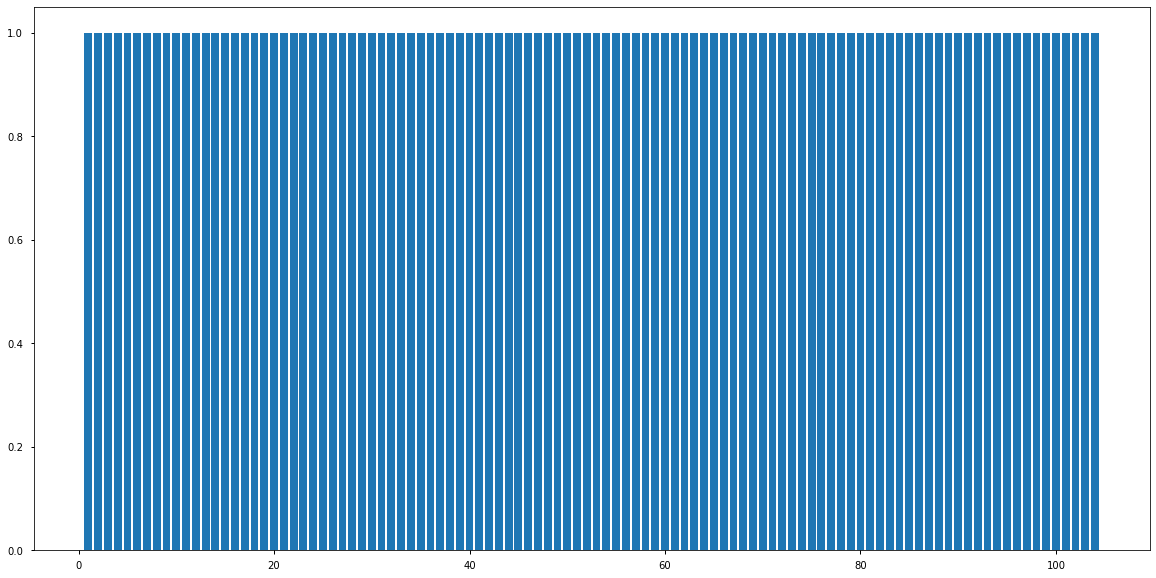

In [5]:
case_counts = possums['case'].value_counts()

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(case_counts.index, case_counts);

We'll plan to keep this variable out of our model!

### `'site'`

What about `site`?

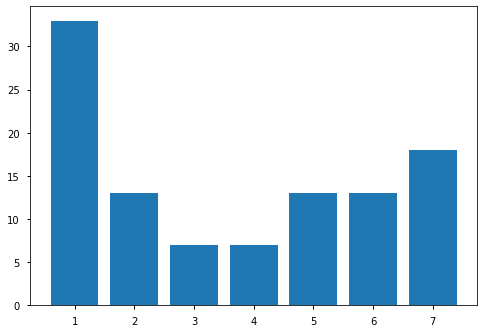

In [6]:
site_counts = possums['site'].value_counts()

fig, ax = plt.subplots()
ax.bar(site_counts.index, site_counts);

Well this looks more interesting. But notice that we don't have any reason to think that the numbers of these sites are meaningful *as numbers*. We're going to want to treat this variable  in the same way that we'll treat `Pop` and `sex`, i.e. like a **categorical variable**.

Before we go any further let's also check for null values:

In [7]:
possums.isna().sum()

case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

That's only three missing values. Let's go ahead and drop those rows:

In [8]:
# Drop Nulls
possums_no_nulls = possums.dropna().reset_index(drop=True)

In [9]:
possums_no_nulls.head()

case  site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  \
0     1     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5   
1     2     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5   
2     3     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4   
3     4     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1   
4     5     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0   

   earconch   eye  chest  belly  
0      54.5  15.2   28.0   36.0  
1      51.2  16.0   28.5   33.0  
2      51.9  15.5   30.0   34.0  
3      52.2  15.2   28.0   34.0  
4      53.2  15.1   28.5   33.0

In [10]:
possums_no_nulls.isnull().sum().sum()

0

Now what if we wanted to compare this `site` variable with our target `age`? EDA with categorical variables can look a bit different from EDA with continuous variables. Check out [this post](https://medium.com/analytics-vidhya/tutorial-exploratory-data-analysis-eda-with-categorical-variables-6a569a3aea55) from FIS's own Erin Hoffman, for example.

Taking a cue from Erin, we might try a histogram of age *for each value of our categorical `site` variable*:

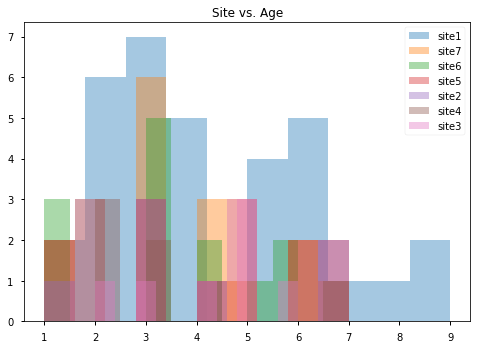

In [11]:
fig, ax = plt.subplots()

for site in possums_no_nulls['site'].value_counts().index:
    ax.hist(possums_no_nulls[possums_no_nulls['site'] == site]['age'],
            alpha=0.4, label=f'site{site}')
plt.legend()
ax.set_title('Site vs. Age');

That's a little hard to see. Let's break this into two plots:

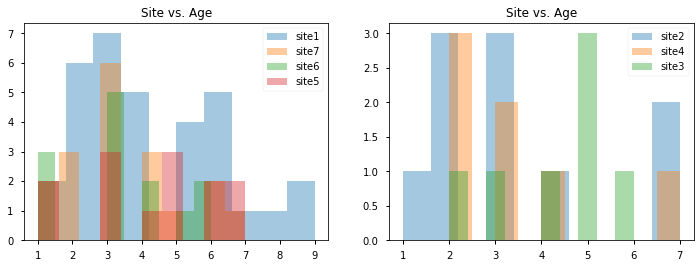

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for site in possums_no_nulls['site'].value_counts().index[:4]:
    ax1.hist(possums_no_nulls[possums_no_nulls['site'] == site]['age'],
            alpha=0.4, label=f'site{site}')
ax1.legend()
ax1.set_title('Site vs. Age')

for site in possums_no_nulls['site'].value_counts().index[4:]:
    ax2.hist(possums_no_nulls[possums_no_nulls['site'] == site]['age'],
            alpha=0.4, label=f'site{site}')
ax2.legend()
ax2.set_title('Site vs. Age');

That's a bit more illuminating.

### `sex` and `Pop`

What vales of `Pop` do we have?

In [13]:
# Value Counts
possums_no_nulls.Pop.value_counts()

other    58
Vic      43
Name: Pop, dtype: int64

In [14]:
possums_no_nulls.sex.value_counts()

m    59
f    42
Name: sex, dtype: int64

Kaggle tells us that these are all Australian possums, each possum coming either from a population in Victoria (`Pop = 'Vic'`) or from a population either in New South Wales or in Queensland (`Pop = 'other'`).

Let's also see what this looks like when we compare it to `age`. This time we'll try a swarmplot from `seaborn`:

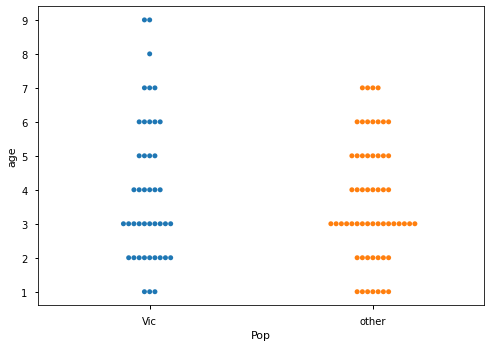

In [15]:
sns.swarmplot(x=possums_no_nulls['Pop'], y=possums_no_nulls['age']);

What about the `sex` variable?

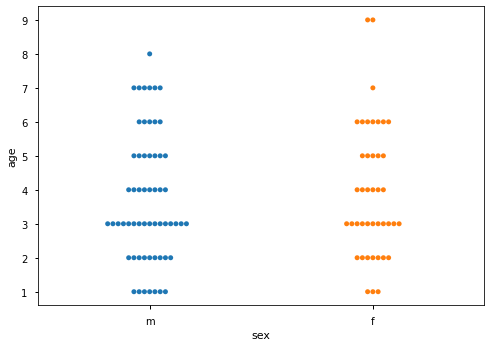

In [16]:
sns.swarmplot(x=possums_no_nulls['sex'], y=possums_no_nulls['age']);

OK, good. Let's get to the dummy-coding.

## Dummying - Code

### `pandas.get_dummies()`

Let's use `pd.get_dummies()` on our variables:

In [17]:
# Get Dummies
pd.get_dummies(possums_no_nulls)

case  site  age  hdlngth  skullw  totlngth  taill  footlgth  earconch  \
0       1     1  8.0     94.1    60.4      89.0   36.0      74.5      54.5   
1       2     1  6.0     92.5    57.6      91.5   36.5      72.5      51.2   
2       3     1  6.0     94.0    60.0      95.5   39.0      75.4      51.9   
3       4     1  6.0     93.2    57.1      92.0   38.0      76.1      52.2   
4       5     1  2.0     91.5    56.3      85.5   36.0      71.0      53.2   
..    ...   ...  ...      ...     ...       ...    ...       ...       ...   
96    100     7  1.0     89.5    56.0      81.5   36.5      66.0      46.8   
97    101     7  1.0     88.6    54.7      82.5   39.0      64.4      48.0   
98    102     7  6.0     92.4    55.0      89.0   38.0      63.5      45.4   
99    103     7  4.0     91.5    55.2      82.5   36.5      62.9      45.9   
100   104     7  3.0     93.6    59.9      89.0   40.0      67.6      46.0   

      eye  chest  belly  Pop_Vic  Pop_other  sex_f  sex_m  
0    15.2   28.0   36.0        1          0      0      1  
1    16.0   28.5   33.0        1          0      1      0  
2    15.5   30.0   34.0        1          0      1      0  
3    15.2   28.0   34.0        1          0      1      0  
4    15.1   28.5   33.0        1          0      1      0  
..    ...    ...    ...      ...        ...    ...    ...  
96   14.8   23.0   27.0        0          1      0      1  
97   14.0   25.0   33.0        0          1      0      1  
98   13.0   25.0   30.0        0          1      1      0  
99   15.4   25.0   29.0        0          1      0      1  
100  14.8   28.5   33.5        0          1      1      0  

[101 rows x 16 columns]

The last four columns show the action of the dummying-out. Notice that `get_dummies()` selects the object columns by default. If we want to dummy out the `site` variable as well, we'll need to ask for that explicitly:

In [18]:
# Dummy up Site
site_dummies = pd.get_dummies( possums_no_nulls.site)

In [19]:
site_dummies

1  2  3  4  5  6  7
0    1  0  0  0  0  0  0
1    1  0  0  0  0  0  0
2    1  0  0  0  0  0  0
3    1  0  0  0  0  0  0
4    1  0  0  0  0  0  0
..  .. .. .. .. .. .. ..
96   0  0  0  0  0  0  1
97   0  0  0  0  0  0  1
98   0  0  0  0  0  0  1
99   0  0  0  0  0  0  1
100  0  0  0  0  0  0  1

[101 rows x 7 columns]

Before we add these dummies to our data let's scale our numerical variables:

In [20]:
# Create Numeric Dataframe
X_nums = possums_no_nulls.drop(['case','site','Pop','sex'], axis=1)


In [21]:
X_nums.head()

age  hdlngth  skullw  totlngth  taill  footlgth  earconch   eye  chest  \
0  8.0     94.1    60.4      89.0   36.0      74.5      54.5  15.2   28.0   
1  6.0     92.5    57.6      91.5   36.5      72.5      51.2  16.0   28.5   
2  6.0     94.0    60.0      95.5   39.0      75.4      51.9  15.5   30.0   
3  6.0     93.2    57.1      92.0   38.0      76.1      52.2  15.2   28.0   
4  2.0     91.5    56.3      85.5   36.0      71.0      53.2  15.1   28.5   

   belly  
0   36.0  
1   33.0  
2   34.0  
3   34.0  
4   33.0

In [22]:
# Standard Scaler!

ss = StandardScaler()


In [23]:
ss.fit(X_nums)

StandardScaler()

In [24]:
ss.mean_

array([ 3.82178218, 92.73069307, 56.96039604, 87.26930693, 37.04950495,
       68.3980198 , 48.13366337, 15.05049505, 27.06435644, 32.63861386])

In [25]:
ss.scale_

array([1.90567698, 3.50125133, 3.08728081, 4.17597425, 1.96189562,
       4.39159819, 4.04020089, 1.05338904, 2.0106934 , 2.71420795])

In [ ]:
ss.fit(X_nums)

In [27]:
# Scaled, numeric dataframe
X_nums_scaled = pd.DataFrame( ss.transform(X_nums), columns=X_nums.columns   )

In [28]:
X_nums_scaled.head()

age   hdlngth    skullw  totlngth     taill  footlgth  earconch  \
0  2.192511  0.391091  1.114121  0.414441 -0.534944  1.389467  1.575748   
1  1.143015 -0.065889  0.207174  1.013103 -0.280089  0.934052  0.758956   
2  1.143015  0.362530  0.984557  1.970964  0.994189  1.594404  0.932215   
3  1.143015  0.134040  0.045219  1.132836  0.484478  1.753799  1.006469   
4 -0.955976 -0.351501 -0.213909 -0.423687 -0.534944  0.592490  1.253981   

        eye     chest     belly  
0  0.141928  0.465334  1.238441  
1  0.901381  0.714004  0.133146  
2  0.426723  1.460016  0.501578  
3  0.141928  0.465334  0.501578  
4  0.046996  0.714004  0.133146

In [29]:
X_nums_scaled.describe()

age       hdlngth        skullw      totlngth         taill  \
count  1.010000e+02  1.010000e+02  1.010000e+02  1.010000e+02  1.010000e+02   
mean   6.265615e-17 -2.091012e-15  3.531828e-15 -1.751624e-15  4.528831e-16   
std    1.004988e+00  1.004988e+00  1.004988e+00  1.004988e+00  1.004988e+00   
min   -1.480724e+00 -2.922010e+00 -2.254539e+00 -2.938071e+00 -2.573789e+00   
25%   -9.559764e-01 -5.799907e-01 -6.349912e-01 -6.631523e-01 -5.349443e-01   
50%   -4.312285e-01  4.835612e-02 -1.815177e-01  1.749755e-01 -2.523322e-02   
75%    6.182673e-01  5.910192e-01  3.691287e-01  6.539056e-01  4.844779e-01   
max    2.717259e+00  2.961600e+00  3.770180e+00  2.210429e+00  3.033033e+00   

           footlgth      earconch           eye         chest         belly  
count  1.010000e+02  1.010000e+02  1.010000e+02  1.010000e+02  1.010000e+02  
mean   3.473294e-15  1.511442e-15  1.181948e-15  1.835715e-16 -6.974619e-16  
std    1.004988e+00  1.004988e+00  1.004988e+00  1.004988e+00  1.004988e+00  
min   -1.843980e+00 -1.691417e+00 -2.136433e+00 -2.518711e+00 -2.814307e+00  
25%   -8.876085e-01 -8.251232e-01 -6.175259e-01 -7.780184e-01 -6.037171e-01  
50%   -1.134029e-01 -3.300983e-01 -1.428675e-01 -3.200709e-02 -5.106973e-02  
75%    9.340518e-01  9.569664e-01  6.165860e-01  4.653338e-01  5.015777e-01  
max    2.163672e+00  1.996519e+00  2.610151e+00  2.454697e+00  2.712167e+00

Now let's add the dummies to our `DataFrame`:

In [30]:
# object categoricals
sex_pop_dummies = pd.get_dummies(possums_no_nulls[['sex','Pop']])

sex_pop_dummies.head()

sex_f  sex_m  Pop_Vic  Pop_other
0      0      1        1          0
1      1      0        1          0
2      1      0        1          0
3      1      0        1          0
4      1      0        1          0

In [31]:
# Concat it all together
X = pd.concat([X_nums_scaled, sex_pop_dummies, site_dummies], axis=1 )

X.head()

age   hdlngth    skullw  totlngth     taill  footlgth  earconch  \
0  2.192511  0.391091  1.114121  0.414441 -0.534944  1.389467  1.575748   
1  1.143015 -0.065889  0.207174  1.013103 -0.280089  0.934052  0.758956   
2  1.143015  0.362530  0.984557  1.970964  0.994189  1.594404  0.932215   
3  1.143015  0.134040  0.045219  1.132836  0.484478  1.753799  1.006469   
4 -0.955976 -0.351501 -0.213909 -0.423687 -0.534944  0.592490  1.253981   

        eye     chest     belly  ...  sex_m  Pop_Vic  Pop_other  1  2  3  4  \
0  0.141928  0.465334  1.238441  ...      1        1          0  1  0  0  0   
1  0.901381  0.714004  0.133146  ...      0        1          0  1  0  0  0   
2  0.426723  1.460016  0.501578  ...      0        1          0  1  0  0  0   
3  0.141928  0.465334  0.501578  ...      0        1          0  1  0  0  0   
4  0.046996  0.714004  0.133146  ...      0        1          0  1  0  0  0   

   5  6  7  
0  0  0  0  
1  0  0  0  
2  0  0  0  
3  0  0  0  
4  0  0  0  

[5 rows x 21 columns]

## Digression: `sklearn.preprocessing.OneHotEncoder`

The `get_dummies()` function is useful for EDA, but when you're building machine learning models and pipelines in Phase 3, it will be important to do any one-hot encoding by using `sklearn`'s tool, the `OneHotEncoder`. The main advantage of this is that it stores information about the columns and creates a persistent function that can be used on future data of the same form. This idea of transforming "future data of the same form" is central to  the predictive statistical work we'll do in later phases. See [this page](https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-are-the-pros-and-cons) for more.

Let's try using this tool now. We can compare and contrast its functionality with `get_dummies()`.

In [32]:
# OHE!
ohe = OneHotEncoder()

possum_cats = possums_no_nulls[['site','sex','Pop']]

ohe.fit(possum_cats)

OneHotEncoder()

In [33]:
# Encoded
possum_encoded = ohe.transform(possum_cats)

In [34]:
possum_encoded


<101x11 sparse matrix of type '<class 'numpy.float64'>'
	with 303 stored elements in Compressed Sparse Row format>

In [37]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit(possum_cats)
possumcat2 = ohe2.transform(possum_cats)

In [38]:
possumcat2

array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Notice that by default the `.transform()` method returns a **sparse matrix**. If we want to see the 1's and 0's we can either override this by setting `sparse=False` in the encoder instance or we can call `todense()` on the sparse matrix:

In [39]:
possum_encoded.todense()

matrix([[1., 0., 0., ..., 1., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

We can also make a `DataFrame` and use the feature names saved in the fit-call as our column headers:

In [40]:
# Pandas, pandas everywhere
pd.DataFrame(possum_encoded.todense(), columns = ohe.get_feature_names())

x0_1  x0_2  x0_3  x0_4  x0_5  x0_6  x0_7  x1_f  x1_m  x2_Vic  x2_other
0     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0     1.0       0.0
1     1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0     1.0       0.0
2     1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0     1.0       0.0
3     1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0     1.0       0.0
4     1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0     1.0       0.0
..    ...   ...   ...   ...   ...   ...   ...   ...   ...     ...       ...
96    0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0     0.0       1.0
97    0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0     0.0       1.0
98    0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0     0.0       1.0
99    0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0     0.0       1.0
100   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0     0.0       1.0

[101 rows x 11 columns]

To cut down on **multicollinearity** among our predictors, in practice we'll not use *all* of the categories for a given variable but rather leave one out. Note that we can do this *without loss of any information*: Take the `sex` column above: If we remove the `x2_m` column we could reproduce it from the values of `x2_f`, since we know that non-female possums (`x2_f=0`) must be male (`x2_m=1`) and that female possums (`x2_f=1`) cannot be male (`x2_m=0`).

This streamlining is easily done with the `sklearn` tool:

In [41]:
ohe3 = OneHotEncoder(drop='first')
ohe3.fit(possum_cats)
possums_encoded = pd.DataFrame(ohe3.transform(possum_cats).todense(),
                               columns=ohe3.get_feature_names())
possums_encoded

x0_2  x0_3  x0_4  x0_5  x0_6  x0_7  x1_m  x2_other
0     0.0   0.0   0.0   0.0   0.0   0.0   1.0       0.0
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0
..    ...   ...   ...   ...   ...   ...   ...       ...
96    0.0   0.0   0.0   0.0   0.0   1.0   1.0       1.0
97    0.0   0.0   0.0   0.0   0.0   1.0   1.0       1.0
98    0.0   0.0   0.0   0.0   0.0   1.0   0.0       1.0
99    0.0   0.0   0.0   0.0   0.0   1.0   1.0       1.0
100   0.0   0.0   0.0   0.0   0.0   1.0   0.0       1.0

[101 rows x 8 columns]

In [42]:
X2 = pd.concat([X_nums_scaled, possums_encoded], axis=1)
X2

age   hdlngth    skullw  totlngth     taill  footlgth  earconch  \
0    2.192511  0.391091  1.114121  0.414441 -0.534944  1.389467  1.575748   
1    1.143015 -0.065889  0.207174  1.013103 -0.280089  0.934052  0.758956   
2    1.143015  0.362530  0.984557  1.970964  0.994189  1.594404  0.932215   
3    1.143015  0.134040  0.045219  1.132836  0.484478  1.753799  1.006469   
4   -0.955976 -0.351501 -0.213909 -0.423687 -0.534944  0.592490  1.253981   
..        ...       ...       ...       ...       ...       ...       ...   
96  -1.480724 -0.922725 -0.311082 -1.381548 -0.280089 -0.546047 -0.330098   
97  -1.480724 -1.179776 -0.732164 -1.142082  0.994189 -0.910379 -0.033083   
98   1.143015 -0.094450 -0.634991  0.414441  0.484478 -1.115316 -0.676616   
99   0.093519 -0.351501 -0.570209 -1.142082 -0.280089 -1.251941 -0.552859   
100 -0.431228  0.248285  0.952166  0.414441  1.503900 -0.181715 -0.528108   

          eye     chest     belly  x0_2  x0_3  x0_4  x0_5  x0_6  x0_7  x1_m  \
0    0.141928  0.465334  1.238441   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
1    0.901381  0.714004  0.133146   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2    0.426723  1.460016  0.501578   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3    0.141928  0.465334  0.501578   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4    0.046996  0.714004  0.133146   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
..        ...       ...       ...   ...   ...   ...   ...   ...   ...   ...   
96  -0.237799 -2.021371 -2.077444   0.0   0.0   0.0   0.0   0.0   1.0   1.0   
97  -0.997253 -1.026689  0.133146   0.0   0.0   0.0   0.0   0.0   1.0   1.0   
98  -1.946570 -1.026689 -0.972149   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
99   0.331791 -1.026689 -1.340580   0.0   0.0   0.0   0.0   0.0   1.0   1.0   
100 -0.237799  0.714004  0.317362   0.0   0.0   0.0   0.0   0.0   1.0   0.0   

     x2_other  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
..        ...  
96        1.0  
97        1.0  
98        1.0  
99        1.0  
100       1.0  

[101 rows x 18 columns]

## `OrdinalEncoder`

Occasionally we want a coding for our categories that preserves some intuitive *ordering* of those categories.

Suppose we had the results of some survey as our dataset, where answers to questions are of the form:

- Strongly Disagree
- Disagree
- Neutral
- Agree
- Strongly Agree

In this case we'd be throwing away information if we used the one-hot strategy. So we might try an encoding like:

<table>
    <tr>
        <th>Category</th>
        <th>Code</th>
    </tr>
    <tr>
        <td>Strongly Disagree</td>
        <td>0</td>
    </tr>
    <tr>
        <td>Disagree</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Neutral</td>
        <td>2</td>
    </tr>
    <tr>
        <td>Agree</td>
        <td>3</td>
    </tr>
    <tr>
        <td>Strongly Agree</td>
        <td>4</td>
    </tr>
</table>

To effect such a strategy we can use `sklearn.preprocessing.OrdinalEncoder`:

In [43]:
survey_results = (3 * ['Strongly Disagree'])
survey_results.extend(3 * ['Disagree'])
survey_results.extend(3 * ['Neutral'])
survey_results.extend(3 * ['Agree'])
survey_results.extend(3 * ['Strongly Agree'])

np.random.seed(42)
np.random.shuffle(survey_results)
survey_preds = pd.DataFrame(survey_results)
survey_preds

0
0               Agree
1               Agree
2   Strongly Disagree
3      Strongly Agree
4            Disagree
5             Neutral
6   Strongly Disagree
7   Strongly Disagree
8      Strongly Agree
9            Disagree
10            Neutral
11              Agree
12     Strongly Agree
13           Disagree
14            Neutral

In [44]:
categories = [['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']]
ords = OrdinalEncoder(categories=categories)
ords.fit(survey_preds)
ords.transform(survey_preds)

array([[3.],
       [3.],
       [0.],
       [4.],
       [1.],
       [2.],
       [0.],
       [0.],
       [4.],
       [1.],
       [2.],
       [3.],
       [4.],
       [1.],
       [2.]])

## Modeling

Now let's throw our data into a linear regression model.

In [45]:
y = possums_no_nulls['age']

In [46]:
X2.head()

age   hdlngth    skullw  totlngth     taill  footlgth  earconch  \
0  2.192511  0.391091  1.114121  0.414441 -0.534944  1.389467  1.575748   
1  1.143015 -0.065889  0.207174  1.013103 -0.280089  0.934052  0.758956   
2  1.143015  0.362530  0.984557  1.970964  0.994189  1.594404  0.932215   
3  1.143015  0.134040  0.045219  1.132836  0.484478  1.753799  1.006469   
4 -0.955976 -0.351501 -0.213909 -0.423687 -0.534944  0.592490  1.253981   

        eye     chest     belly  x0_2  x0_3  x0_4  x0_5  x0_6  x0_7  x1_m  \
0  0.141928  0.465334  1.238441   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
1  0.901381  0.714004  0.133146   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.426723  1.460016  0.501578   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.141928  0.465334  0.501578   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.046996  0.714004  0.133146   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   x2_other  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [49]:
X2_with_const = sm.add_constant(X2.drop('age', axis=1))

In [50]:
sm.OLS(y, X2_with_const).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     2.132
Date:                Fri, 02 Dec 2022   Prob (F-statistic):             0.0138
Time:                        09:55:37   Log-Likelihood:                -191.23
No. Observations:                 101   AIC:                             416.5
Df Residuals:                      84   BIC:                             460.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9502      0.875      5.660      0.000       3.211       6.690
hdlngth        0.4716      0.343      1.375      0.173      -0.210       1.154
skullw         0.2891      0.285      1.015      0.313      -0.277       0.855
totlngth      -0.0918      0.410     -0.224      0.823      -0.907       0.723
taill          0.3753      0.339      1.107      0.271      -0.299       1.049
footlgth      -0.7749      0.426     -1.820      0.072      -1.621       0.072
earconch      -0.0633      0.542     -0.117      0.907      -1.140       1.014
eye            0.2113      0.224      0.945      0.347      -0.233       0.656
chest          0.3226      0.294      1.099      0.275      -0.261       0.906
belly          0.3296      0.247      1.335      0.185      -0.161       0.820
x0_2           0.1827      0.797      0.229      0.819      -1.402       1.767
x0_3          -0.2424      0.641     -0.378      0.706      -1.517       1.032
x0_4          -2.0355      0.714     -2.853      0.005      -3.454      -0.617
x0_5           0.5135      0.595      0.862      0.391      -0.671       1.698
x0_6           0.0813      0.694      0.117      0.907      -1.300       1.462
x0_7          -0.0145      0.504     -0.029      0.977      -1.017       0.988
x1_m          -0.1503      0.408     -0.368      0.714      -0.962       0.662
x2_other      -1.6976      1.214     -1.398      0.166      -4.113       0.717
==============================================================================
Omnibus:                        4.179   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                3.503
Skew:                           0.410   Prob(JB):                        0.173
Kurtosis:                       3.400   Cond. No.                     2.67e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.64e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Notice how the model now includes parameters for our dummies! But here's a question: How do we **interpret** them?

In the case of skull width (`skullw`), we have a beta of 0.2891, and that means that we can expect a possum's age to grow by 0.2891 years if we increase its skull width by 1 mm.

But take the beta for `x1_other`. The value there is -1.6976. How can we understand this? This value encodes the difference we can expect in our target (age, here) when we *increase the variable by one unit*. But for this variabe, "increasing it by one unit" means going from `x1_other=0` to `x1_other=1`, and *that* means going from a possum from the Victoria population to a possum from either the New South Wales or the Queensand population. So it's critical always to keep in mind when interpreting the coefficients of categorical variables in a linear regression model that they must be interpreted against a **baseline**, which is where the values of the inputs are 0. Notice that, for the same reason, this also affects the interpretation of the intercept term.

For more on the interpretation of regression coefficients for categorical variables, see [Erin's repo](https://github.com/hoffm386/coefficients-of-dropped-categorical-variables).

## Exercise

Go back to the variable `X` that has *all* the categorical columns (NOT `X2`) and try building a regression model based on dropping *other* categories than what we just dropped. For example, what happens if we drop the "female" rather than the "male" column, or if we drop the "other population" column rather than the "Victoria population" column?

<details>
    <summary>One answer here</summary>
<code>preds = X.drop(['Pop_other', 'sex_m', 1], axis=1)
preds_const = sm.add_constant(preds)
sm.OLS(y, preds_const).fit().summary()</code>
</details>